# Phase 5 Univariate Time Series Forecasting

In [1]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from metrics import evaluate
import metrics

import pickle
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
# from bayes_opt import BayesianOptimization
# from gluonts.dataset.common import ListDataset
# from gluonts.evaluation.backtest import make_evaluation_predictions
# from gluonts.model.deepar import DeepAREstimator
# from gluonts.mx.trainer import Trainer
# from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from rich.progress import track

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 18, 8
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# change text color
import colorama
from colorama import Fore, Style

print(tf.__version__)

2.0.0


In [2]:
# IPython
from IPython.display import IFrame

正在读取【横截面】数据......
读取完毕
正在读取【时间序列】数据......
读取完毕
正在获取并处理【上海】数据（数据来自上海卫健委）......
读取完毕


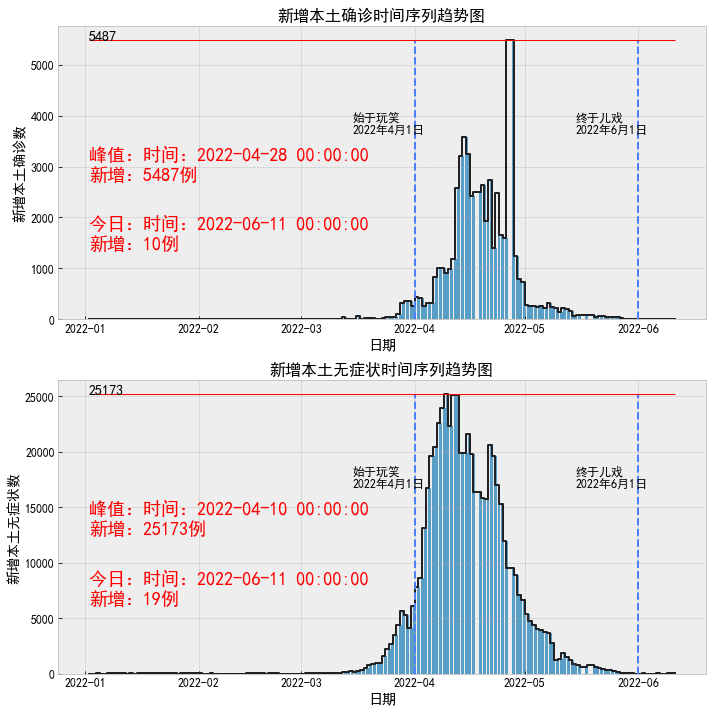

In [3]:
from getdata import GET_csse_covid_19_daily_reports,GET_csse_covid_19_time_series,GET_shanghai_data

# get data
latest_data_global,prev_data_global,latest_data_us,prev_data_us = GET_csse_covid_19_daily_reports()
ts_confirmed_us,ts_confirmed_global,ts_deaths_us,ts_deaths_global,ts_recovered_global = GET_csse_covid_19_time_series()
ts_shanghai_covid = GET_shanghai_data(plot=True)  # 这里包含近10天的上海无症状新增趋势！

In [4]:
from data_processing import ts_process_CHINA,ts_process_US,daily_process

In [5]:
ts_confirmed_CHINA_incre, loc_data_CHINA, sorted_provinces = ts_process_CHINA(ts_confirmed_global,clip=False)
ts_deaths_CHINA_incre, _, _ = ts_process_CHINA(ts_deaths_global,clip=False)
ts_recovered_CHINA_incre, _, _ = ts_process_CHINA(ts_recovered_global,clip=False)

In [6]:
ts_confirmed_US_incre,loc_data_us,sorted_state = ts_process_US(ts_confirmed_us,clip=False)
ts_deaths_US_incre,_,_,population = ts_process_US(ts_deaths_us,death = True,clip=False)

In [7]:
latest_data_CHINA = daily_process(latest_data_global, country = 'China')
prev_data_CHINA = daily_process(prev_data_global, country = 'China')
latest_data_US = daily_process(latest_data_us, country = 'US')
prev_data_US = daily_process(prev_data_us, country = 'US')

## Data preperation & processing



```python
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
```

In [8]:
split_date = '2022-01-01'
df_train = ts_confirmed_US_incre.loc[ts_confirmed_US_incre.index < split_date]
df_test = ts_confirmed_US_incre.loc[ts_confirmed_US_incre.index >= split_date]
print(f"{len(df_train)} days of training data \n {len(df_test)} days of testing data ")

710 days of training data 
 165 days of testing data 


In [9]:
resultsDict = {}
predictionsDict = {}

这里我们计算这四个指标来作为代表：

 metrics=("mae", "rmse", "mape", "r2")

In [10]:
mean = df_train['New York'].mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test['New York'], mean)
predictionsDict['Naive mean'] = mean
resultsDict['Yesterdays value'] = evaluate(
    df_test['New York'], df_test['New York'].shift(1).fillna(0))
predictionsDict['Yesterdays value'] = df_test['New York'].shift(1).fillna(0).values

In [12]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)                           # index表示df_train的行数
yhat = list()                                   # tmp list for prediction storage
for t in track(range(len(df_test['New York']))):     # track是一个类似于tqdm的进度条工具，看：https://zhuanlan.zhihu.com/p/470320311
    temp_train = ts_confirmed_US_incre[:len(df_train)+t] # 使用nested cv 进行训练集的构建
    model = SimpleExpSmoothing(temp_train['New York'])   # SimpleExpSmoothing是简单指数平滑的函数，这里是构建模型
    model_fit = model.fit()                              # fit train
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))  # 遍历测试数据，提前 1 天对所有测试数据进行训练和预测
    yhat = yhat + [predictions]    # predictions加到 yhat中

yhat_SES = pd.concat(yhat)      
resultsDict['SES'] = evaluate(df_test['New York'], yhat_SES.values)
predictionsDict['SES'] = yhat_SES.values

Output()

In [13]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = ExponentialSmoothing(temp_train['New York'])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat_HWES = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test['New York'], yhat_HWES.values)
predictionsDict['HWES'] = yhat_HWES.values

Output()

In [14]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = AR(temp_train['New York'])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat_AR = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test['New York'], yhat_AR.values)
predictionsDict['AR'] = yhat_AR.values

Output()

In [15]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = ARMA(temp_train['New York'],order=(0, 1))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat_MA = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test['New York'], yhat_MA.values)
predictionsDict['MA'] = yhat_MA.values

Output()

#### Autoregressive Moving Average (ARMA)

In [16]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = ARMA(temp_train['New York'].diff().fillna(0),order=(1, 1))
    model_fit = model.fit(transparams=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat_ARMA = pd.concat(yhat)
resultsDict['ARMA'] = evaluate(df_test['New York'], yhat_ARMA.values)
predictionsDict['ARMA'] = yhat_ARMA.values

Output()

In [17]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = ARIMA(temp_train['New York'],order=(1,0,0))
    model_fit = model.fit(transparams=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat_ARIMA = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test['New York'], yhat_ARIMA.values)
predictionsDict['ARIMA'] = yhat_ARIMA.values

Output()

In [18]:
autoModel = pm.auto_arima(df_train['New York'], trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=True)
# autoModel.plot_diagnostics(figsize=(14,10))
# plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=13347.733, Time=0.52 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=14640.016, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=14145.272, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=13346.430, Time=0.48 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=13363.877, Time=0.23 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=13562.254, Time=0.42 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=13364.415, Time=0.79 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=13346.874, Time=0.74 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=13433.366, Time=0.31 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=13332.877, Time=0.88 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=13340.164, Time=0.49 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=13337.682, Time=1.12 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=inf, Time=0.92 sec
 ARIMA(3,2,2)(0,0,0)[0]        

In [19]:
best_order = autoModel.order
model0 = ARIMA(df_train['New York'],order = best_order)
model_fit0 =model0.fit(disp=False)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = ARIMA(temp_train['New York'],order = best_order)
    model_fit = model.fit(disp=False,transparams=False,start_params = model_fit0.params)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train),dynamic=False)
    yhat = yhat + [predictions]
yhat_autoarima = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(best_order)] = evaluate(
    df_test['New York'], yhat_autoarima)
predictionsDict['AutoARIMA {0}'.format(best_order)] = yhat_autoarima.values

Output()

#### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [20]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = SARIMAX(temp_train['New York'],order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False,transparams=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train),dynamic=False)
    yhat = yhat + [predictions]
    
yhat_SARIMAX = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test['New York'], yhat_SARIMAX.values)
predictionsDict['SARIMAX'] = yhat_SARIMAX.values

Output()

#### Auto - SARIMA

In [21]:
# building the model
autoModel = pm.auto_arima(df_train['New York'], trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=6, stepwise=True)
# autoModel.plot_diagnostics(figsize=(14,10))
# plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[6]             : AIC=13313.882, Time=1.99 sec
 ARIMA(0,2,0)(0,0,0)[6]             : AIC=14640.016, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[6]             : AIC=14146.943, Time=0.12 sec
 ARIMA(0,2,1)(0,0,1)[6]             : AIC=inf, Time=0.59 sec
 ARIMA(2,2,2)(0,0,1)[6]             : AIC=13327.855, Time=1.51 sec
 ARIMA(2,2,2)(1,0,0)[6]             : AIC=13366.697, Time=0.53 sec
 ARIMA(2,2,2)(2,0,1)[6]             : AIC=13317.165, Time=2.75 sec
 ARIMA(2,2,2)(1,0,2)[6]             : AIC=13319.170, Time=2.98 sec
 ARIMA(2,2,2)(0,0,0)[6]             : AIC=13347.733, Time=0.47 sec
 ARIMA(2,2,2)(0,0,2)[6]             : AIC=13316.638, Time=2.19 sec
 ARIMA(2,2,2)(2,0,0)[6]             : AIC=13363.630, Time=1.18 sec
 ARIMA(2,2,2)(2,0,2)[6]             : AIC=13356.190, Time=3.70 sec
 ARIMA(1,2,2)(1,0,1)[6]             : AIC=inf, Time=1.79 sec
 ARIMA(2,2,1)(1,0,1)[6]             : AIC=13411.952, Time=1.30 sec
 ARIMA(3,2,2)(1,0,1)[6]        

In [22]:
best_order = autoModel.order
seasonalOrder = autoModel.seasonal_order
# model0 = ARIMA(df_train['New York'],order = best_order)
# model_fit0 =model0.fit(disp=False)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = SARIMAX(temp_train['New York'],
                    order = best_order,
                   seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False,transparams=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train),dynamic=False)
    yhat = yhat + [predictions]
yhat_AutoSARIMAX = pd.concat(yhat)
resultsDict['AutoSARIMAX  {0}'.format(best_order,seasonalOrder)] = evaluate(
    df_test['New York'], yhat_AutoSARIMAX)
predictionsDict['AutoSARIMAX  {0}'.format(best_order,seasonalOrder)] = yhat_AutoSARIMAX.values

Output()

In [23]:
yhat_dict = {
    'SES':yhat_SES,
    'HWES':yhat_HWES,
    'AR':yhat_AR,
    'MA':yhat_MA,
    'ARMA':yhat_ARMA,
    'ARIMA':yhat_ARIMA,
    'AUTOARIMA':yhat_autoarima,
    'SARIMAX':yhat_SARIMAX,
    'AUTOSARIMAX':yhat_AutoSARIMAX
}

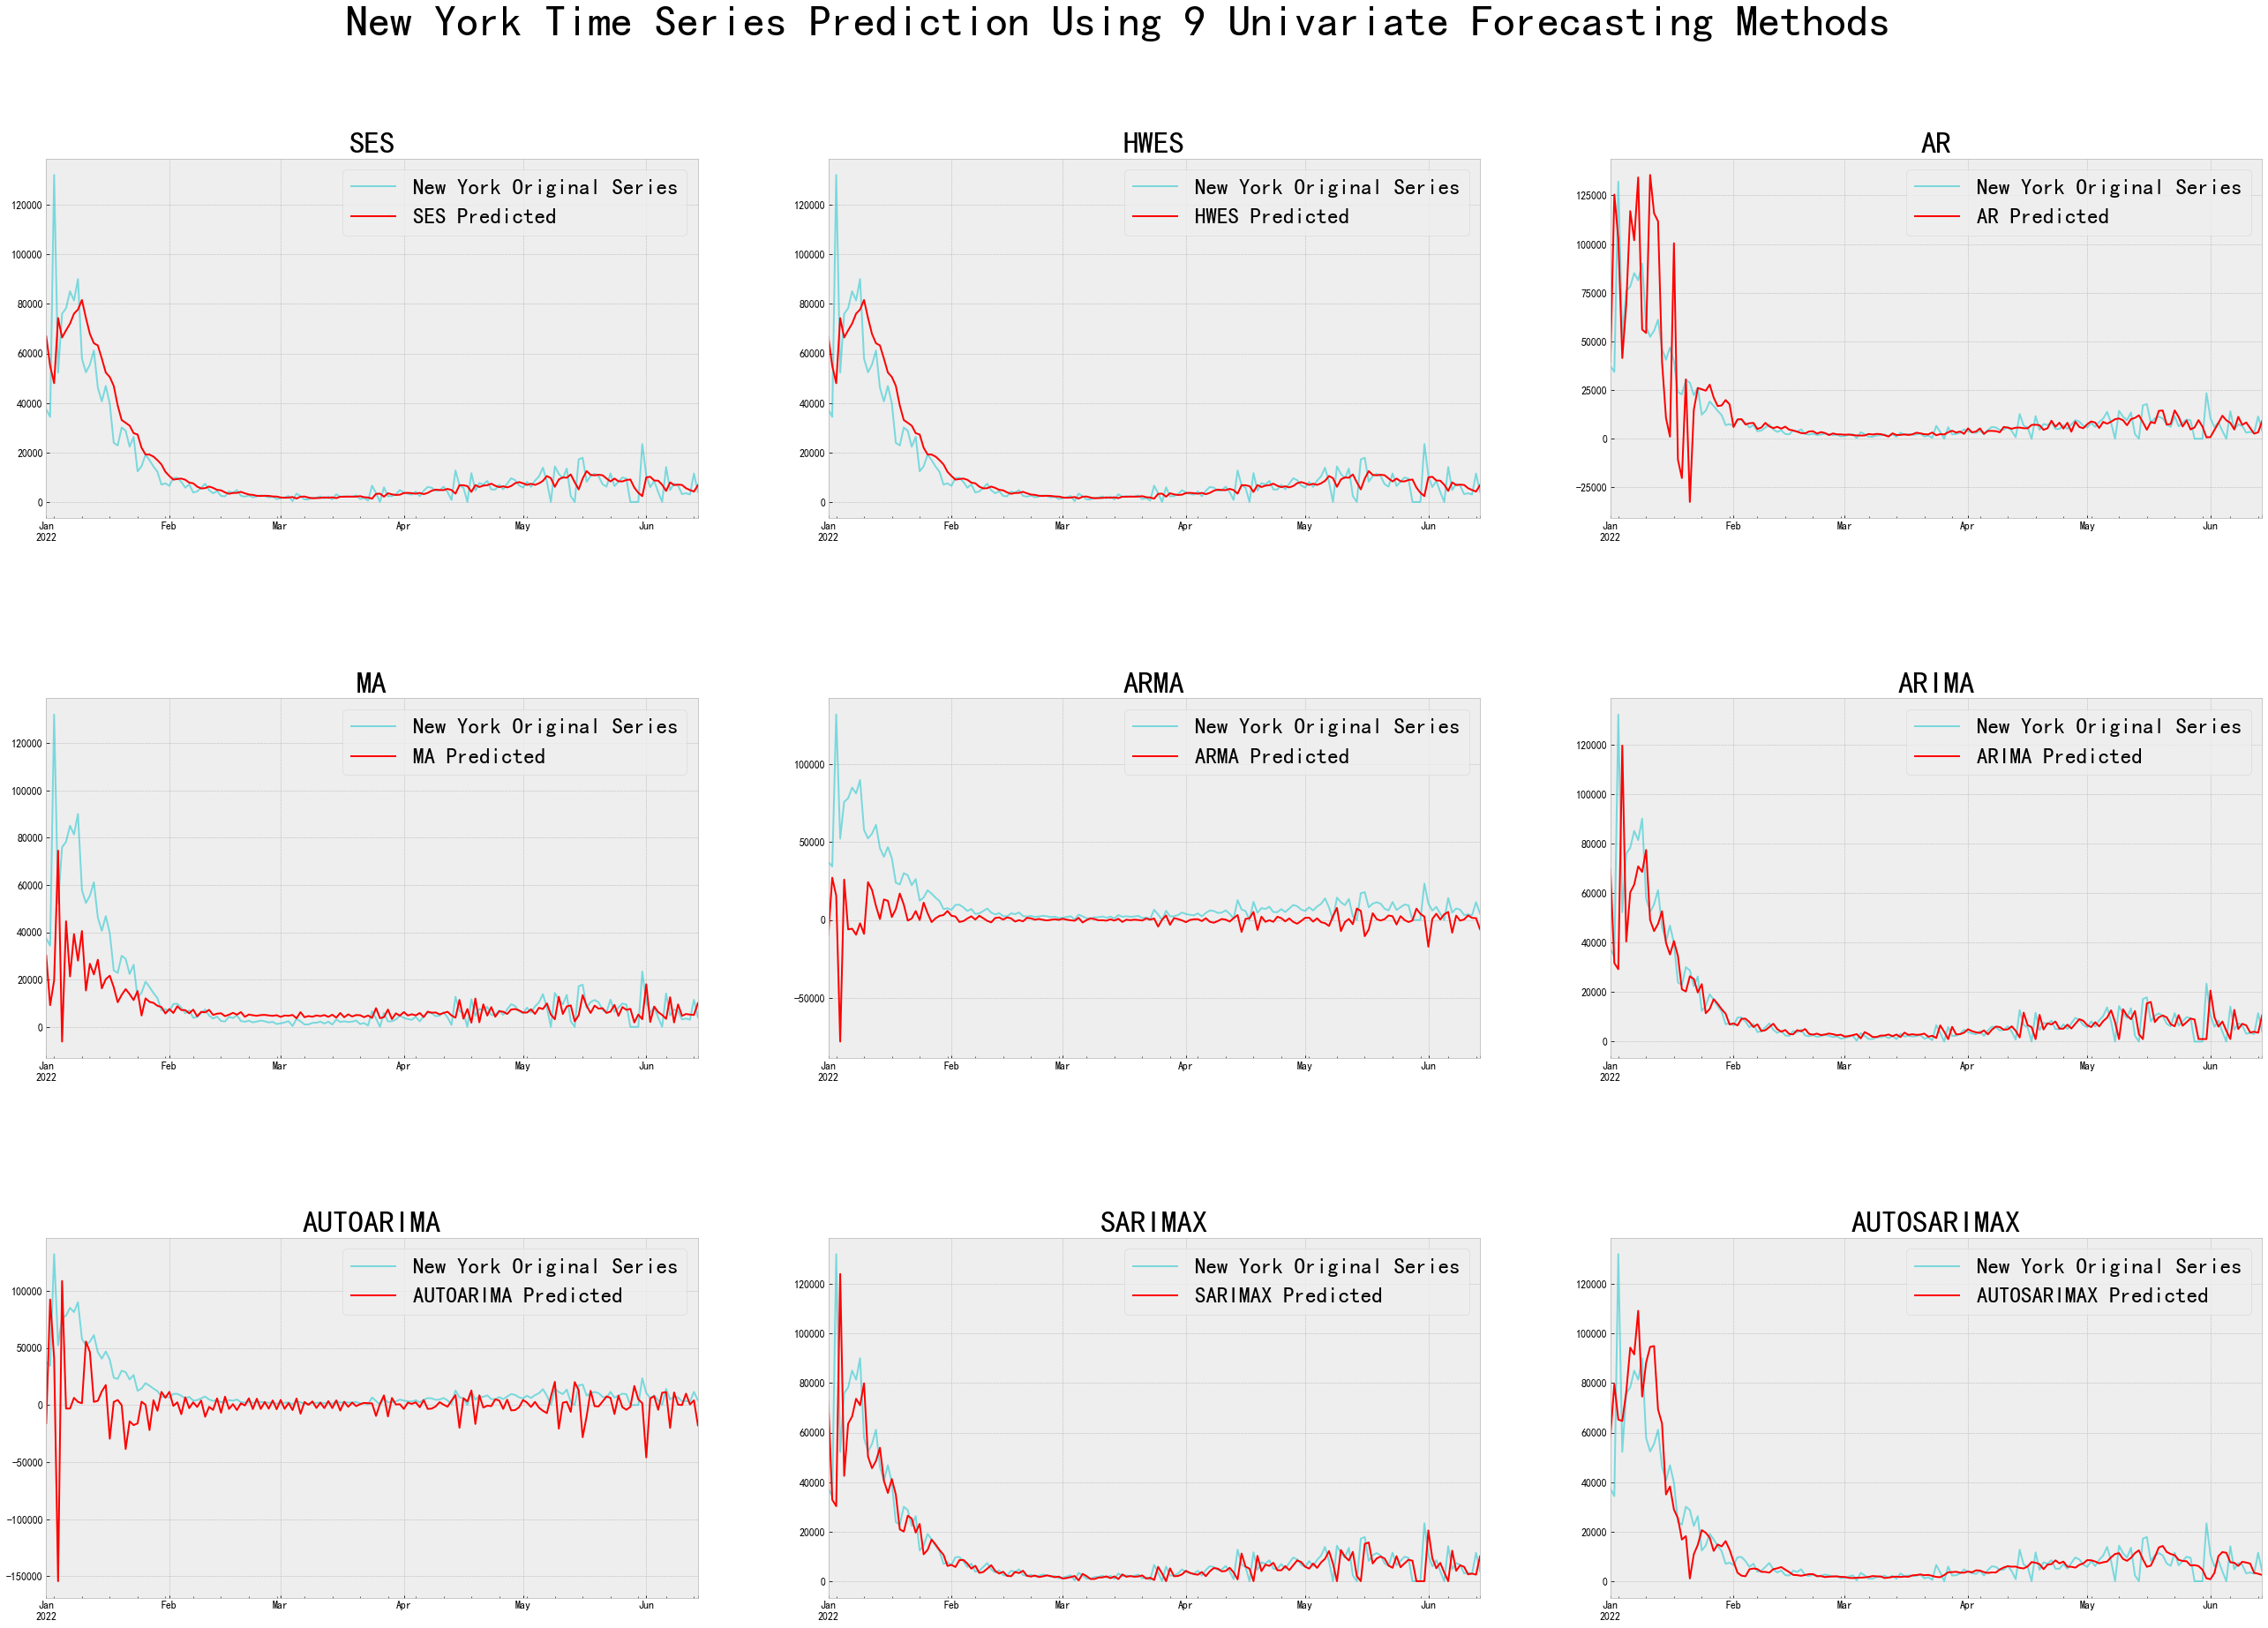

In [24]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(3*15, 10*3))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("New York Time Series Prediction Using 9 Univariate Forecasting Methods", fontsize=50, y = .96)
for yhat_key,ax in zip(yhat_dict.keys(), axs.ravel()):
    df_test['New York'].plot(ax=ax,alpha = .5, label = "New York Original Series", color = '#06c3cc')
    yhat_dict[yhat_key].plot(ax=ax,color = 'red',label=f'{yhat_key} Predicted')
    ax.set_title(f"{yhat_key.upper()}",fontsize = 35)
    ax.legend(fontsize = 25)
    ax.set_xlabel("")
plt.show()